In [5]:
#http://brandonrose.org/clustering
#http://scikit-learn.org/stable/user_guide.html

In [72]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
from bs4 import BeautifulSoup

In [79]:
#import three lists: titles, links and wikipedia synopses
titles = open('document_cluster/title_list.txt').read().split('\n')
titles = titles[:100]

In [80]:
links = open('document_cluster/link_list_imdb.txt').read().split('\n')
links = links[:100]

In [81]:
synopses_wiki = open('document_cluster/synopses_list_wiki.txt').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

In [82]:
synopses_clean_wiki = []
for text in synopses_wiki:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_wiki.append(text)
synopses_wiki = synopses_clean_wiki

In [83]:
genres = open('document_cluster/genres_list.txt').read().split('\n')
genres = genres[:100]

In [84]:
print(str(len(titles)) + ' titles')
print(str(len(links)) + ' links')
print(str(len(synopses_wiki)) + ' synopses')
print(str(len(genres)) + ' genres')

100 titles
100 links
100 synopses
100 genres


In [85]:
synopses_imdb = open('document_cluster/synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

synopses_clean_imdb = []

for text in synopses_imdb:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_imdb.append(text)

synopses_imdb = synopses_clean_imdb

In [86]:
synopses = []

for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)

In [87]:
# generates index for each item in the corpora (in this case it's just rank) and I'll use this for scoring later
ranks = []

for i in range(0,len(titles)):
    ranks.append(i)

In [88]:
stopwords = nltk.corpus.stopwords.words('english')

In [89]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')

In [90]:
def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) ]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [91]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [92]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

In [94]:
%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)
print(tfidf_matrix.shape)
tfidf_matrix.toarray()


CPU times: user 11.6 s, sys: 93.9 ms, total: 11.7 s
Wall time: 11.7 s
(100, 563)


array([[ 0.01530758,  0.04670508,  0.        , ...,  0.05833449,
         0.04017049,  0.        ],
       [ 0.05828674,  0.        ,  0.        , ...,  0.        ,
         0.00955983,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.01326616,  0.14841378,  0.        , ...,  0.        ,
         0.01740667,  0.        ],
       [ 0.01413212,  0.        ,  0.        , ...,  0.0269275 ,
         0.01854291,  0.        ],
       [ 0.20333483,  0.        ,  0.        , ...,  0.        ,
         0.06669946,  0.        ]])

In [120]:
terms = tfidf_vectorizer.get_feature_names()

In [2]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

NameError: name 'tfidf_matrix' is not defined

In [122]:
dist

array([[  0.00000000e+00,   8.00539634e-01,   7.62813109e-01, ...,
          6.41312416e-01,   6.70578229e-01,   8.23926244e-01],
       [  8.00539634e-01,  -2.22044605e-16,   7.33477850e-01, ...,
          7.33117814e-01,   7.71609239e-01,   8.92974798e-01],
       [  7.62813109e-01,   7.33477850e-01,   0.00000000e+00, ...,
          7.23806699e-01,   7.49489708e-01,   8.58673233e-01],
       ..., 
       [  6.41312416e-01,   7.33117814e-01,   7.23806699e-01, ...,
          0.00000000e+00,   4.50879024e-01,   9.17464687e-01],
       [  6.70578229e-01,   7.71609239e-01,   7.49489708e-01, ...,
          4.50879024e-01,   2.22044605e-16,   8.68599864e-01],
       [  8.23926244e-01,   8.92974798e-01,   8.58673233e-01, ...,
          9.17464687e-01,   8.68599864e-01,  -2.22044605e-16]])

In [1]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()
clusters

NameError: name 'tfidf_matrix' is not defined

In [124]:
from sklearn.externals import joblib

#joblib.dump(km,  'doc_cluster.pkl')
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [125]:
import pandas as pd

films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters, 'genre': genres }

frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])

In [126]:
frame

,rank,title,cluster,genre
0,0,The Godfather,0,"[u' Crime', u' Drama']"
0,1,The Shawshank Redemption,0,"[u' Crime', u' Drama']"
3,2,Schindler's List,3,"[u' Biography', u' Drama', u' History']"
4,3,Raging Bull,4,"[u' Biography', u' Drama', u' Sport']"
3,4,Casablanca,3,"[u' Drama', u' Romance', u' War']"
0,5,One Flew Over the Cuckoo's Nest,0,[u' Drama']
0,6,Gone with the Wind,0,"[u' Drama', u' Romance', u' War']"
4,7,Citizen Kane,4,"[u' Drama', u' Mystery']"
0,8,The Wizard of Oz,0,"[u' Adventure', u' Family', u' Fantasy', u' Mu..."
0,9,Titanic,0,"[u' Drama', u' Romance']"


In [127]:
grouped = frame['rank'].groupby(frame['cluster'])

grouped.mean()

cluster
0    50.810345
1    59.428571
2    52.600000
3    39.900000
4    52.600000
Name: rank, dtype: float64

In [130]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    print()
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words: Police, killed, car, home, family, house,

Cluster 0 titles: The Godfather, The Shawshank Redemption, One Flew Over the Cuckoo's Nest, Gone with the Wind, The Wizard of Oz, Titanic, Psycho, Sunset Blvd., Vertigo, On the Waterfront, Forrest Gump, West Side Story, E.T. the Extra-Terrestrial, The Silence of the Lambs, Chinatown, Singin' in the Rain, Some Like It Hot, 12 Angry Men, Amadeus, Gandhi, Unforgiven, Rocky, A Streetcar Named Desire, To Kill a Mockingbird, The Best Years of Our Lives, My Fair Lady, Ben-Hur, Doctor Zhivago, Butch Cassidy and the Sundance Kid, The Treasure of the Sierra Madre, The Apartment, High Noon, The Pianist, Goodfellas, The Exorcist, The French Connection, City Lights, Mr. Smith Goes to Washington, Rain Man, Out of Africa, Good Will Hunting, Fargo, Giant, The Grapes of Wrath, Shane, The Green Mile, Close Encounters of the Third Kind, The Graduate, American Graffiti, Pulp Fiction, The Maltese Falcon, A Clockwork Orange,

In [131]:
frame['Rank'] = frame['rank'] + 1
frame['Title'] = frame['title']

In [132]:
#export tables to HTML
print(frame[['Rank', 'Title']].loc[frame['cluster'] == 1].to_html(index=False))

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Rank</th>
      <th>Title</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>27</td>
      <td>It's a Wonderful Life</td>
    </tr>
    <tr>
      <td>42</td>
      <td>The Philadelphia Story</td>
    </tr>
    <tr>
      <td>44</td>
      <td>An American in Paris</td>
    </tr>
    <tr>
      <td>66</td>
      <td>The King's Speech</td>
    </tr>
    <tr>
      <td>68</td>
      <td>A Place in the Sun</td>
    </tr>
    <tr>
      <td>76</td>
      <td>Tootsie</td>
    </tr>
    <tr>
      <td>100</td>
      <td>Yankee Doodle Dandy</td>
    </tr>
  </tbody>
</table>


In [133]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [141]:
pos.ndim

2

In [135]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [136]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}

In [137]:
%matplotlib inline

/Library/Python/2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/Library/Python/2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/Library/Python/2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/Library/Python/2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int()

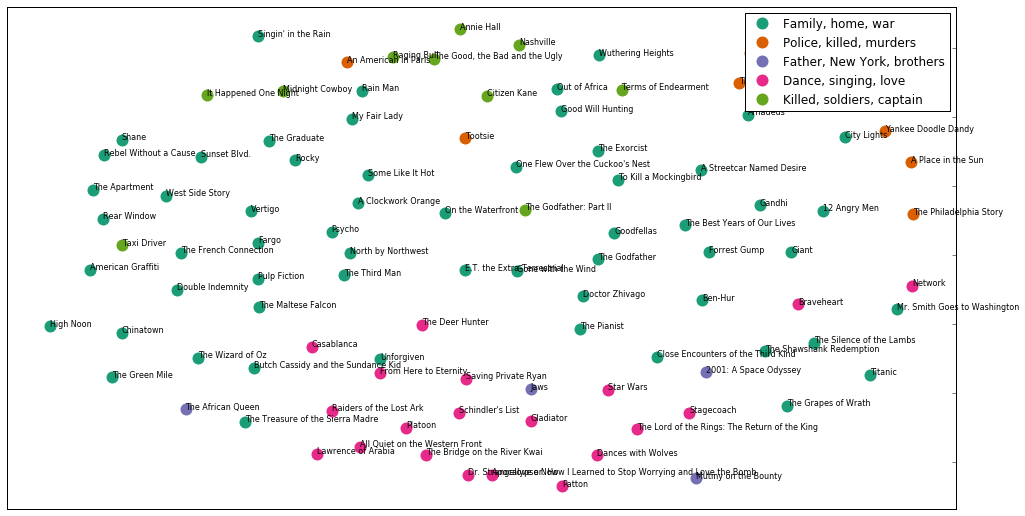

In [138]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

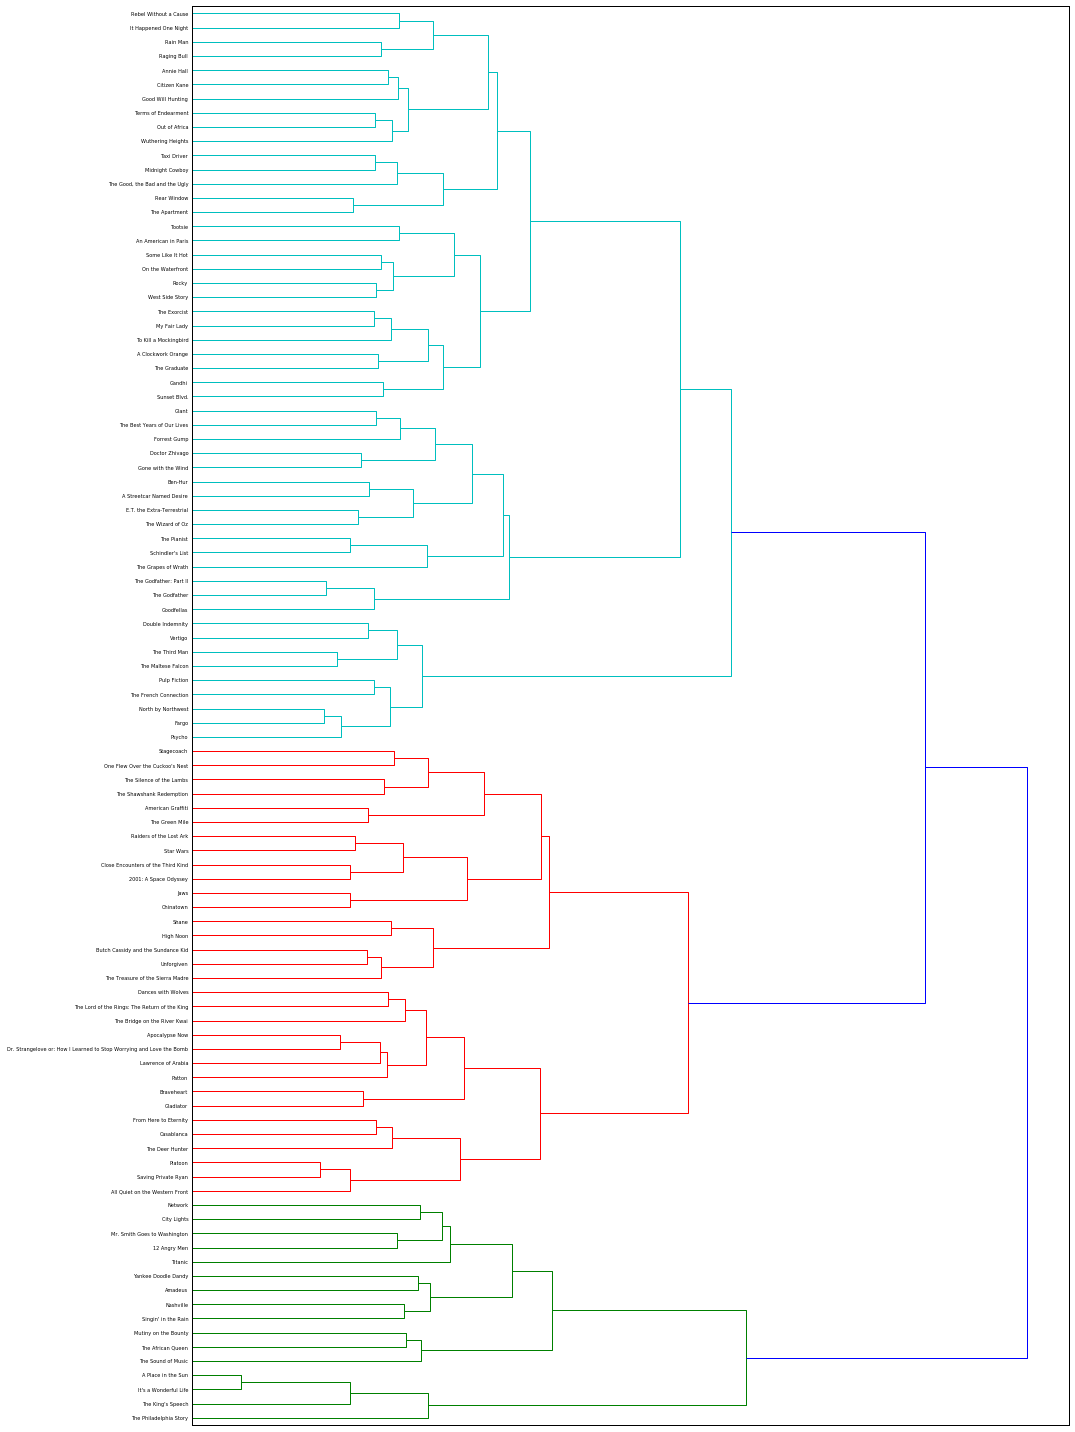

In [142]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters